# CHATBOT

In [1]:
from convokit import Corpus, download

corpus = Corpus(filename=download("movie-corpus"))

# DATA PREPROCESSING

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import convokit
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
from collections import Counter
from convokit import Corpus, download
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def tokenize(text):
    return word_tokenize(text.lower())

conversations = []
for conv_id in corpus.get_conversation_ids():
    conversation = []
    for utt in corpus.get_conversation(conv_id).iter_utterances():
        conversation.append(tokenize(utt.text))
    conversations.append(conversation)

word_counter = Counter()
for conv in conversations:
    for utterance in conv:
        word_counter.update(utterance)

PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
vocab_size = 10000
vocab = [PAD_TOKEN, UNK_TOKEN, SOS_TOKEN, EOS_TOKEN] + [word for word, count in word_counter.most_common(vocab_size - 4)]
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

def words_to_indices(words):
    indices = []
    for word in words:
        if isinstance(word, list):
            indices.extend([word2idx.get(w, word2idx[UNK_TOKEN]) for w in word if w in word2idx])
        else:
            indices.append(word2idx.get(word, word2idx[UNK_TOKEN]))
    return indices

class MovieDataset(Dataset):
    def __init__(self, conversations, word2idx):
        self.conversations = conversations
        self.word2idx = word2idx
        
    def __len__(self):
        return len(self.conversations)
    
    def __getitem__(self, index):
        conversation = self.conversations[index]
        src = [word2idx[SOS_TOKEN]] + words_to_indices(conversation[:-1]) + [word2idx[EOS_TOKEN]]
        trg = [word2idx[SOS_TOKEN]] + words_to_indices(conversation[1:]) + [word2idx[EOS_TOKEN]]
        return torch.tensor(src), torch.tensor(trg)

def collate_fn(batch):
    src_seqs, trg_seqs = zip(*batch)
    src_seqs = pad_sequence(src_seqs, padding_value=word2idx[PAD_TOKEN])
    trg_seqs = pad_sequence(trg_seqs, padding_value=word2idx[PAD_TOKEN])
    return src_seqs, trg_seqs

movie_dataset = MovieDataset(conversations, word2idx)
batch_size = 64
movie_loader = DataLoader(movie_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

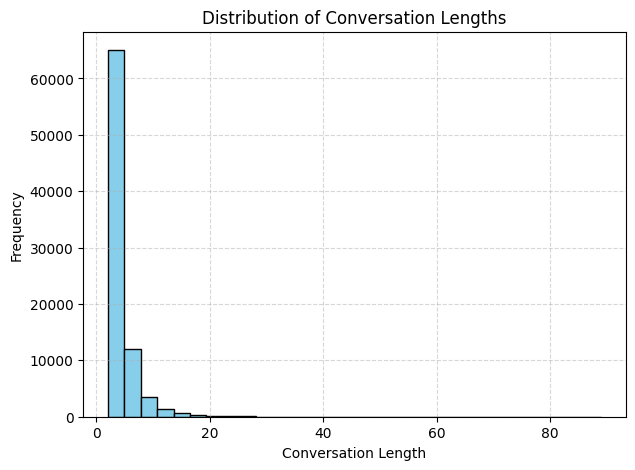

In [61]:
conversation_lengths = [len(conv) for conv in conversations]

plt.figure(figsize=(7, 5))
plt.hist(conversation_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Conversation Length')
plt.ylabel('Frequency')
plt.title('Distribution of Conversation Lengths')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

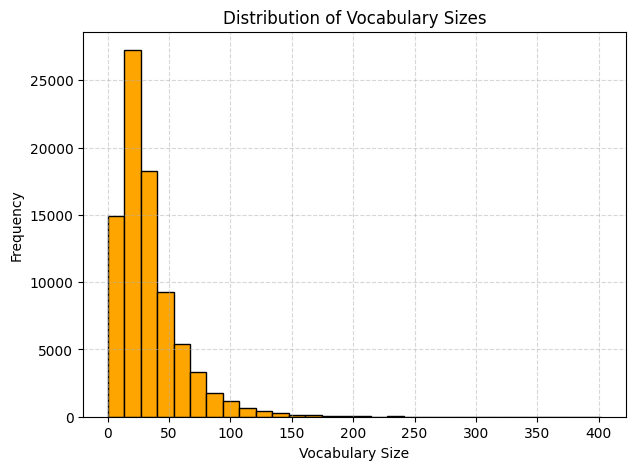

In [60]:
vocab_sizes = [len(set(word for utterance in conv for word in utterance)) for conv in conversations]

plt.figure(figsize=(7, 5))
plt.hist(vocab_sizes, bins=30, color='orange', edgecolor='black')
plt.xlabel('Vocabulary Size')
plt.ylabel('Frequency')
plt.title('Distribution of Vocabulary Sizes')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ARCHITECTURE

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = OUTPUT_DIM
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        encoder_hidden, encoder_cell = self.encoder(src)
        encoder_outputs = src
        
        decoder_input = trg[0,:]
        
        for t in range(1, trg_len):
            output, encoder_hidden, encoder_cell = self.decoder(decoder_input, encoder_hidden, encoder_cell, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            decoder_input = trg[t] if teacher_force else top1
        
        return outputs

# TRAIN

In [4]:
num_samples_to_keep = 500
indices_to_keep = torch.randperm(len(movie_dataset))[:num_samples_to_keep]

reduced_movie_dataset = Subset(movie_dataset, indices_to_keep)
reduced_movie_loader = DataLoader(reduced_movie_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = len(word2idx)
OUTPUT_DIM = len(word2idx)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
N_EPOCHS = 10

encoder = Encoder(INPUT_DIM, 256, 512, 2, 0.5).to(device)
decoder = Decoder(OUTPUT_DIM, 256, 512, 2, 0.5).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD_TOKEN])

epoch_losses = []
for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0
    
    for src, trg in reduced_movie_loader:
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_losses.append(epoch_loss / len(reduced_movie_loader))
    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {epoch_loss / len(reduced_movie_loader)}')

Epoch [1/10], Train Loss: 8.053938746452332
Epoch [2/10], Train Loss: 5.819543838500977
Epoch [3/10], Train Loss: 5.7153090834617615
Epoch [4/10], Train Loss: 5.64863383769989
Epoch [5/10], Train Loss: 5.637500047683716
Epoch [6/10], Train Loss: 5.614234030246735
Epoch [7/10], Train Loss: 5.602934122085571
Epoch [8/10], Train Loss: 5.599931180477142
Epoch [9/10], Train Loss: 5.597906649112701
Epoch [10/10], Train Loss: 5.598341107368469


In [7]:
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0
    
    with torch.no_grad():
        for src, trg in data_loader:
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            eval_loss += loss.item()

    return eval_loss / len(data_loader)

movie_loader = DataLoader(reduced_movie_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
eval_loss = evaluate(model, movie_loader, criterion)
print(f'Evaluation Loss: {eval_loss}')

Evaluation Loss: 5.4016717348098755


# LOSS PLOT

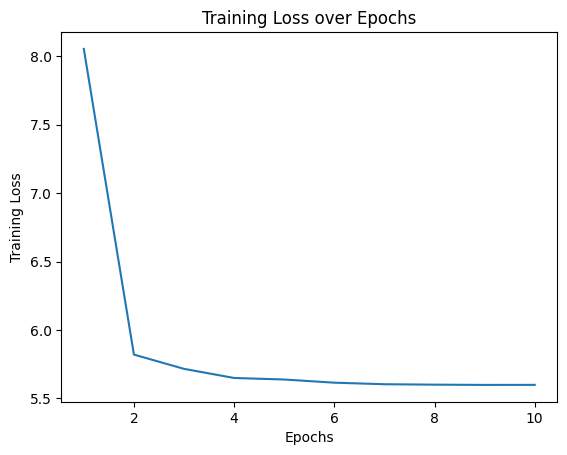

In [44]:
plt.plot(range(1, N_EPOCHS + 1), epoch_losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

# PREDICT

In [42]:
def predict(model, sentence, max_len=50):
    model.eval()
    
    tokens = tokenize(sentence)
    src_indexes = [word2idx[SOS_TOKEN]] + [word2idx[token] if token in word2idx else word2idx[UNK_TOKEN] for token in tokens] + [word2idx[EOS_TOKEN]]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    trg_indexes = [word2idx[SOS_TOKEN]]
    
    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(1).to(device)
        
        with torch.no_grad():
            output = model(src_tensor, trg_tensor)
        
        pred_token = output.argmax(-1)[-1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == word2idx[EOS_TOKEN]:
            break
    
    trg_tokens = [idx2word[idx] for idx in trg_indexes]
    trg_tokens = [token for token in trg_tokens if token not in [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN]]
    
    return trg_tokens

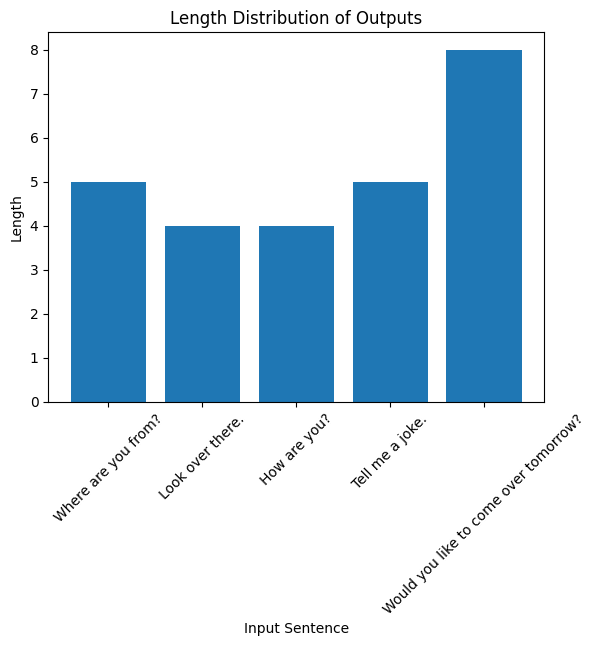

In [43]:
def predict_multiple(model, sentences):
    predictions = []
    for sentence in sentences:
        predictions.append(predict(model, sentence))
    return predictions

input_sentences = ["Where are you from?", "Look over there.", "How are you?", "Tell me a joke.", 
                   "Would you like to come over tomorrow?"]

predictions = predict_multiple(model, input_sentences)

input_lengths = [len(tokenize(sentence)) for sentence in input_sentences]
plt.bar(range(len(input_lengths)), input_lengths)
plt.xlabel("Input Sentence")
plt.ylabel("Length")
plt.title("Length Distribution of Outputs")
plt.xticks(range(len(input_sentences)), input_sentences, rotation=45)
plt.show()

# WORD EMBEDDINGS

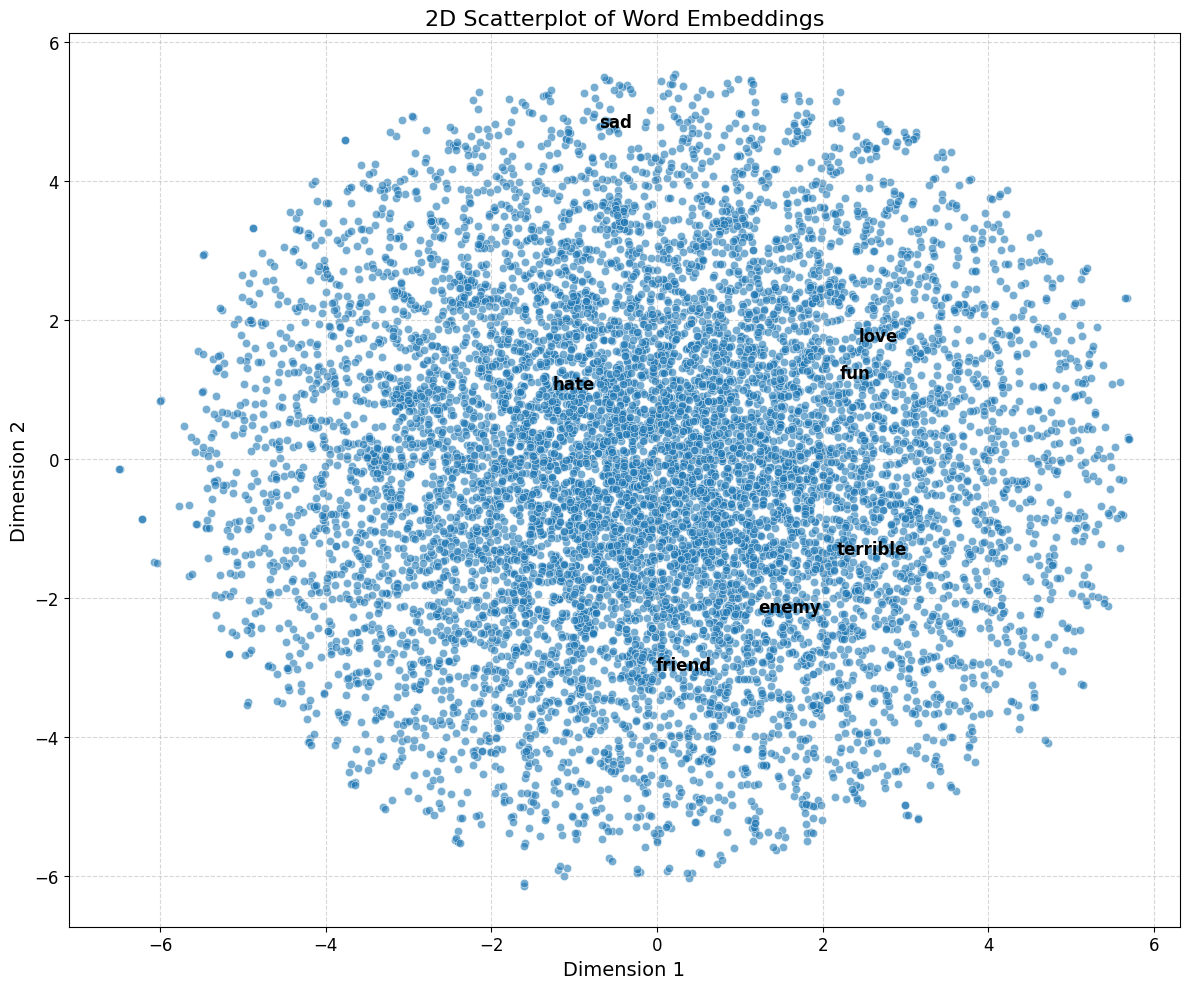

In [36]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.6, edgecolors='w', linewidths=0.5)

words_to_annotate = ['love', 'hate', 'friend', 'enemy', 'sad', 'terrible', 'fun']
for word in words_to_annotate:
    idx = word2idx.get(word, word2idx[UNK_TOKEN])
    plt.annotate(word, (word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1]), fontsize=12, fontweight='bold')

plt.title('2D Scatterplot of Word Embeddings', fontsize=16)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()